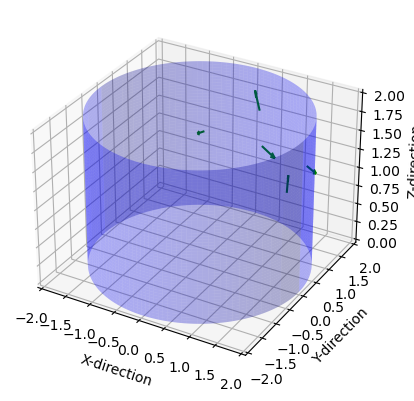

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from scipy.spatial.transform import Rotation
from numpy.linalg import norm
import plotly.graph_objs as go


# Constants/parameters and coefficients
k_values = {"k_C": 6/6, "k_F": 4/6, "k_T": 2/6, "k_L": 3/6, "k_SO": 5/6, "k_ST": 1/12}  #Hierarchical coefficients
dpref_bottom = 0.5  #meters
dpref_surface = 0.5  #meters
dpref_wall = 0.5  #meters
dpref_fish = 0.5 #meters, trying to change this to body length of each induvidual fish
react_dist = 0.6  #meters
max_speed = 1.2  #m/s
average_speed = 0.6  #m/s
# Parameters for the simulation
num_fish = 5 
cage_radius = 2  # Example radius
cage_depth = 2  # Example depth
num_steps = 100  # Example number of steps

class Fish:
    def __init__(self, position, velocity, tau, size, fish_id):
        self.id = fish_id
        self.position = position
        self.velocity = velocity
        self.tau = tau
        self.size = size
        self.r_dot_prev = np.zeros(3)
        self.delta_l = 0.66 * self.size  #Based on 0.66 Body Lengths as the minimum preferred distance
        self.delta_h = 3 * self.size  #Based on 3 Body Lengths as the maximum reaction distance
        
        #Behaviour: response to cage and water surface
    def v_cs(self, position):
        d_surf = cage_depth-position[2]
        if d_surf <= dpref_surface : #Dobbelcheck this
            v_cs = np.array([0, 0, -1]) * (dpref_surface - d_surf)
        else:
            v_cs = np.array([0, 0, 0])
        return v_cs
    
    def v_cb(self, position):
        d_bottom = position[2]
        if d_bottom <= dpref_bottom :
            v_cb = np.array([0, 0, 1]) * (dpref_bottom - d_bottom)
        else:
            v_cb = np.array([0, 0, 0])
        return v_cb
    
    def v_cw(self, position):#Create a unit vector pointing towards the center of the cage
        d_wall = cage_radius - np.sqrt(position[0]**2 + position[1]**2)
        if d_wall <= dpref_wall:
            direction_to_center = np.array([-position[0], -position[1], 0])
            norm = np.linalg.norm(direction_to_center[:2])
            if norm != 0: 
                unit_vec_center = direction_to_center/norm
            else:
                unit_vec_center = direction_to_center
            v_cw = unit_vec_center * (dpref_wall - d_wall)
        else:
            v_cw = np.array([0, 0, 0])
        return v_cw

    #Stochastic component
    def get_rotation_matrix(self, velocity):
        if norm(velocity) > 0:
            direction = velocity / norm(velocity)
            if abs(direction[2]) != 1:
                non_collinear = np.array([0, 0, 1])
                v1 = np.cross(direction, non_collinear)
                v1 /= norm(v1)
                v2 = np.cross(direction, v1)
                rotation_matrix = np.array([direction, v1, v2]).T  # Transposed for correct alignment
            else:
                v1 = np.array([1, 0, 0])
                v2 = np.array([0, 1, 0])
                if direction[2] < 0:  #Pointing down
                    direction = -direction  #Make the 'forward' direction point upwards for consistency
                rotation_matrix = np.array([direction, v1, v2]).T
            return rotation_matrix
        return np.eye(3)

    def stochastic_component(self, sigma=0.25):
        # This now assumes the fish always moves forward ('1') and experiences lateral and vertical stochastic perturbations
        random_vector = np.array([1, np.random.normal(0, sigma), np.random.normal(0, sigma)])
        rotation_matrix = self.get_rotation_matrix(self.velocity)
        V_ST = rotation_matrix.dot(random_vector)
        return V_ST

    def update_neighbors(self, all_fish, threshold_distance):
        self.neighbors = [f for f in all_fish if 0 < np.linalg.norm(f.position - self.position) <= threshold_distance]


    def social_response(self, neighbors):
        """
        Calculate the social response of a fish towards its neighbors.
        This method implements the behavior described in Equation 7 of the provided material.

        :param neighbors: A list of all other fish objects.
        :param delta_l: The preferred minimum distance to neighbors.
        :param delta_h: The maximum reaction distance to neighbors.
        :return: The social velocity vector as a numpy array.
        """
        self.neighbors = []  # This should be replaced with actual neighbor fish
        v_so = np.zeros(3)  # Initialize social velocity vector
        for neighbor in neighbors:
            dij = neighbor.position - self.position  # Distance vector between fish i and j
            rij_dot = neighbor.velocity  # Velocity vector of fish j
            #print('dij',dij)
            if np.linalg.norm(dij) <= self.delta_l:
                # If too close, swim away from the neighbor
                v_so_j = dij * (self.delta_l - np.linalg.norm(dij))
            elif self.delta_l <= np.linalg.norm(dij) <= self.delta_h:
                # If within preferred distance, try aligning with the neighbor
                v_so_j = 0.5 * rij_dot * (np.linalg.norm(dij) - self.delta_h) / (self.delta_h - self.delta_l)
            else:
                # Otherwise, no response
                v_so_j = np.zeros(3)
            
            v_so += v_so_j  # Sum up the individual responses
        
        return v_so / len(neighbors) if neighbors else v_so  # Return the average if there are neighbors

    

    def velocity_ode(self, t, y):
        # Unpack the current position and velocity from y
        position, velocity = y[:3], y[3:]
        V_c = (self.v_cs(position) + self.v_cb(position) + self.v_cw(position))
        V_f = 0  # Replace with actual calculation
        V_T = 0  # Replace with actual calculation
        V_L = 0  # Replace with actual calculation
        V_SO = self.social_response(self.neighbors)
        V_ST = self.stochastic_component()
        #print('V_SO', self.id, V_SO)
        # Compute new velocity using the reference velocity equation
        r_dot_ref = self.tau * self.r_dot_prev + (1 - self.tau) * (k_values["k_C"] * V_c + k_values["k_F"] * V_f +
                                                            k_values["k_T"] * V_T + k_values["k_L"] * V_L +
                                                            k_values["k_SO"] * V_SO + k_values["k_ST"] * V_ST)
        self.r_dot_prev = r_dot_ref
        #print('ref',self.r_dot_prev)
        #print('velocity', velocity)
        return np.concatenate((velocity, r_dot_ref))


    def update_position(self, dt):
        # Initial conditions for solve_ivp [position, velocity]
        y0 = np.concatenate((self.position, self.velocity))
        # Time span for the ODE solver for one step of the simulation
        t_span = (0, float(dt))  # Ensure dt is cast to float

        # Solve the ODE
        sol = solve_ivp(self.velocity_ode, t_span, y0, method='RK45')

        # Update fish position and velocity with the last solution step
        self.position, self.velocity = sol.y[:3, -1], sol.y[3:, -1]

class SeaCage:
    def __init__(self, radius, depth):
        self.radius = radius
        self.depth = depth

"""    def is_inside(self, position):
        radial_distance = np.sqrt(position[0]**2 + position[1]**2)
        return radial_distance <= self.radius and 0 <= position[2] <= self.depth"""
class Simulation:
    def __init__(self, num_fish, cage_radius, cage_depth):
        self.fish = []
        for fish_id in range(num_fish):
            size = np.random.uniform(0.3, 0.4) #meters
            radius = np.random.uniform(0, cage_radius)
            angle = np.random.uniform(0, 2 * np.pi)
            depth = np.random.uniform(0, cage_depth)
            position = np.array([radius * np.cos(angle), radius * np.sin(angle), depth]) #Start position
            signs = np.random.choice([-1, 1], size=3) #Chose random direction
            velocity = np.random.normal(0.5 * size, 0.2 * size, 3)*signs #Start velocity (BL/S), normal distribution
            self.fish.append(Fish(position, velocity, tau=0.6, size=size, fish_id=fish_id))
        self.cage = SeaCage(cage_radius, cage_depth)

    def run(self, num_steps, visualize=False):
        if visualize:
            plt.ion()
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_xlim3d([-self.cage.radius, self.cage.radius])
            ax.set_ylim3d([-self.cage.radius, self.cage.radius])
            ax.set_zlim3d([0, self.cage.depth])
            x = np.linspace(-self.cage.radius, self.cage.radius, 1000)
            z = np.linspace(0, self.cage.depth, 1000)
            Xc, Zc = np.meshgrid(x, z)
            Yc = np.sqrt(self.cage.radius**2 - Xc**2)

        dt = 1.0/10 # Time step
        for _ in range(num_steps):
            for fish in self.fish:
                fish.update_neighbors(self.fish, react_dist)

            if visualize:
                ax.clear()
                ax.plot_surface(Xc, Yc, Zc, alpha=0.3, color='blue')
                ax.plot_surface(Xc, -Yc, Zc, alpha=0.3, color='blue')
                ax.set_xlim3d([-self.cage.radius, self.cage.radius])
                ax.set_ylim3d([-self.cage.radius, self.cage.radius])
                ax.set_zlim3d([0, self.cage.depth])
                ax.set_xlabel('X-direction')
                ax.set_ylabel('Y-direction')
                ax.set_zlabel('Z-direction')

            for fish in self.fish:
                fish.update_position(dt)
                if visualize:
                    #ax.scatter(fish.position[0], fish.position[1], fish.position[2], color='red', marker='>', s=fish.size*100)
                    # Plotting the quiver plot for the velocity vectors
                    ax.quiver(fish.position[0], fish.position[1], fish.position[2], fish.velocity[0], fish.velocity[1], fish.velocity[2], color='green', length=fish.size, normalize=True)

            if visualize:
                plt.pause(0.01)

        if visualize:
            plt.show()

# Run the simulation with visualization
simulation = Simulation(num_fish, cage_radius, cage_depth)
simulation.run(num_steps, visualize=True)